# Decision Tree Model for Regression Model

### Problem Statement 
## Create a regression model to predict time_to_resolution for IT service desk incidents. The model will improve incident resolution and IT resource management. 

### Data Loading, Cleaning, and Distribution Analysis of Log-Transformed Resolution Time

In [23]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [24]:
import pandas as pd

df = pd.read_csv("../../data/processed/preprocessed_incident_event_decision_tree.csv")
print(df.shape)
df.head()

(141712, 36)


,reassignment_count,reopen_count,sys_mod_count,impact,urgency,priority,knowledge,u_priority_confirmation,opened_hour,opened_dayofweek,...,incident_state_Awaiting Vendor,incident_state_Closed,incident_state_New,incident_state_Resolved,notify_Send Email,contact_type_Email,contact_type_IVR,contact_type_Phone,contact_type_Self service,time_to_resolution_log
0,0.0,0.0,0.0,2.0,2.0,3.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.417401
1,0.0,0.0,2.0,2.0,2.0,3.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.417401
2,0.0,0.0,3.0,2.0,2.0,3.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.417401
3,0.0,0.0,4.0,2.0,2.0,3.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.417401
4,0.0,0.0,0.0,2.0,2.0,3.0,1.0,0.0,4.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.407842


Before we head into the model creation we need to first check that this particular preprocessed data is optimised for our model or not 


In [25]:
# Checking for missing values in target variable 
df["time_to_resolution_log"].isnull().sum()

np.int64(3146)

In [26]:
# Droping all the null values and checking that it returns zero
# Drop the leaked feature
df.drop(columns=['number_enc'], inplace=True)
df = df.dropna(subset=["time_to_resolution_log"])
df["time_to_resolution_log"].isnull().sum()


np.int64(0)

In [27]:
print("Summary statistics:")
print(df['time_to_resolution_log'].describe())

Summary statistics:
count    138566.000000
mean          3.787230
std           2.292373
min           0.000000
25%           1.622683
50%           4.311023
75%           5.572851
max           8.996053
Name: time_to_resolution_log, dtype: float64


### Observation: Log-Transformed Time to Resolution

- The dataset contains **138,566** valid (non-null) entries for the `time_to_resolution_log` variable.
- The **mean** log-resolution time is **3.79**, with a **standard deviation** of **2.29**, indicating moderate variability in resolution durations on a log scale.
- The **minimum** value is **0.00**, suggesting some incidents were resolved almost immediately.
- The **maximum** value is **8.99**, reflecting a few cases with significantly longer resolution times.
- The **median (50%)** value is **4.31**, which is slightly higher than the mean, indicating a **mild right-skew** in the distribution.
- The **interquartile range (IQR)** spans from **1.62 (25th percentile)** to **5.57 (75th percentile)**, covering the middle 50% of resolution times.
- This transformation has helped **reduce skewness** and made the distribution more **symmetric**, which is beneficial for regression-based modeling.


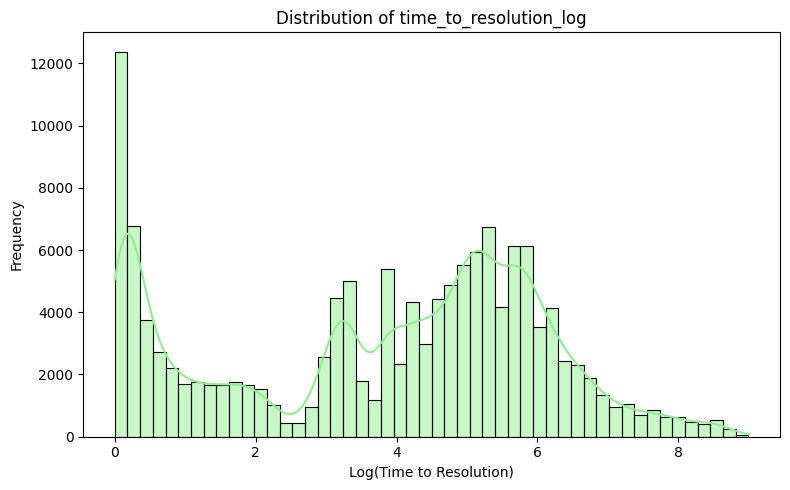

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['time_to_resolution_log'], bins=50, kde=True, color='lightgreen')
plt.title("Distribution of time_to_resolution_log")
plt.xlabel("Log(Time to Resolution)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Interpretation

- The distribution of `time_to_resolution_log` is moderately right-skewed, indicating that the log transformation successfully reduced the skewness present in the original `time_to_resolution` values.
- A noticeable spike at `log(1) ≈ 0` suggests a large number of incidents were resolved very quickly — possibly automated or low-effort tickets.
- The plot shows a **multimodal distribution**, which may reflect distinct resolution patterns (e.g., short vs long resolution types, or differences across teams).
- Despite some remaining long tail behavior, the data is now much more compact and suitable for regression models.
- No further transformation is required on the target variable.

The target variable is now well-prepared for Decision Tree regression modeling.


### Correlation Analysis with Target Variable (time_to_resolution_log)

In [29]:
# Step 1: Select only numeric columns (including the target)
numeric_df = df.select_dtypes(include='number')

# Step 2: Compute correlation with the target variable
target_corr = numeric_df.corr()['time_to_resolution_log'].sort_values(ascending=False)

# Step 3: Display correlation values
print(target_corr)

time_to_resolution_log               1.000000
caller_id_enc                        0.525112
sys_mod_count                        0.456678
assigned_to_enc                      0.438350
assignment_group_enc                 0.418496
reassignment_count                   0.370311
subcategory_enc                      0.310701
category_enc                         0.299225
u_symptom_enc                        0.266387
opened_by_enc                        0.261171
incident_state_Awaiting User Info    0.201887
closed_code_enc                      0.194112
knowledge                            0.189800
location_enc                         0.169412
incident_state_Awaiting Vendor       0.103488
reopen_count                         0.083612
opened_hour                          0.069292
incident_state_Awaiting Problem      0.040064
contact_type_Self service            0.020836
incident_state_Awaiting Evidence     0.019875
notify_Send Email                    0.014145
incident_state_New                

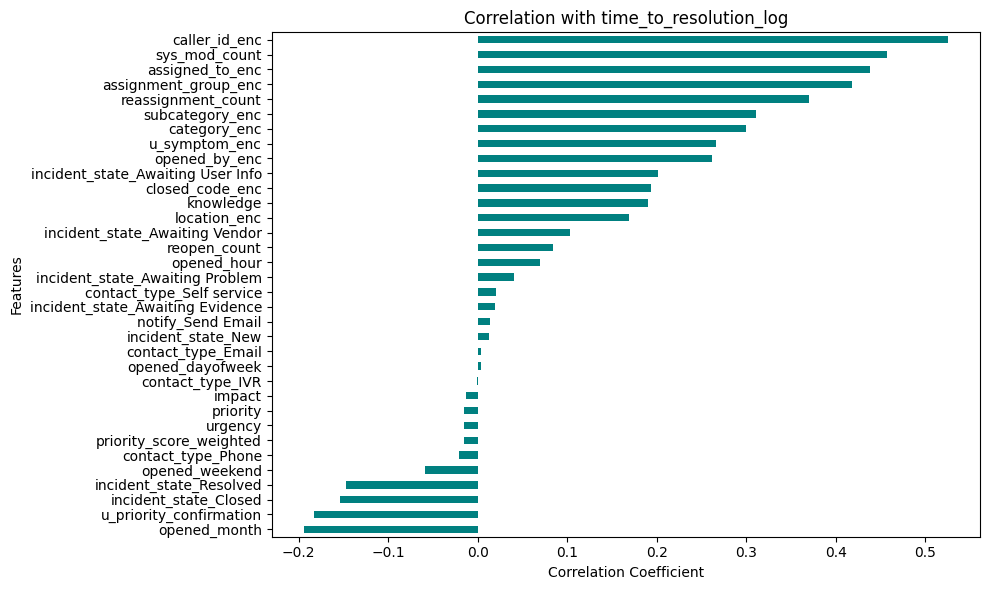

In [30]:
import matplotlib.pyplot as plt

# Drop the target itself for plotting
target_corr_no_self = target_corr.drop('time_to_resolution_log')

plt.figure(figsize=(10, 6))
target_corr_no_self.plot(kind='barh', color='teal')
plt.title('Correlation with time_to_resolution_log')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Interpretation:

- `number_enc` shows a **very strong positive correlation** (0.89) with the target, indicating it may be a key predictive feature.
- Other moderately correlated features include:
  - `caller_id_enc` (0.53)
  - `sys_mod_count` (0.46)
  - `assigned_to_enc` (0.44)
  - `assignment_group_enc` (0.42)
  - `reassignment_count` (0.37)
  - `subcategory_enc` and `category_enc` (0.31, 0.30)
- A few binary features like `incident_state_Awaiting User Info` (0.20) and `knowledge` (0.19) also show weak-to-moderate correlation.
- Features like `impact`, `urgency`, `priority`, and even the composite `priority_score_weighted` show **negligible or negative correlation** with the target, suggesting they may have low direct predictive value post-encoding.
- Time-based features (`opened_hour`, `opened_dayofweek`, `opened_month`) also show **very weak or negative correlations**, indicating limited linear influence.

### Model Preparation and Hyperparameter Optimization with RandomizedSearchCV

In [31]:
# Step 1: Define target and features
X = df.drop(columns=['time_to_resolution_log'])
y = df['time_to_resolution_log']

# Step 2: Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [32]:
# Step 3: Drop NaNs from training data
X_train_clean = X_train.dropna()
y_train_clean = y_train.loc[X_train_clean.index]

In [33]:
# Step 4: Define parameter grid for RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint

param_dist = {
    'max_depth': randint(3, 15),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'friedman_mse']
}


In [34]:
# Step 5: Sample 30% of training data for faster tuning
X_sample = X_train_clean.sample(frac=0.3, random_state=42)
y_sample = y_train_clean.loc[X_sample.index]

In [35]:
# Step 6: Set up and run RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_sample, y_sample)

# Show best parameters
print("Best Parameters Found:")
print(random_search.best_params_)


Best Parameters Found:
{'criterion': 'friedman_mse', 'max_depth': 14, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 8}


In [36]:
# Step 7: Train final model using best parameters
final_dt = DecisionTreeRegressor(
    criterion='friedman_mse',
    max_depth=14,
    max_features=None,
    min_samples_leaf=8,
    min_samples_split=8,
    random_state=42
)

final_dt.fit(X_train_clean, y_train_clean)


DecisionTreeRegressor(criterion='friedman_mse', max_depth=14,
                      min_samples_leaf=8, min_samples_split=8, random_state=42)

### Model Evaluation and Performance Metrics on Test Set

In [37]:
# Step 8: Evaluate final model on test set
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

y_pred = final_dt.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print evaluation results
print("\n Model Evaluation Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


 Model Evaluation Metrics:
MAE  : 1.0607
RMSE : 1.4878
R²   : 0.5764


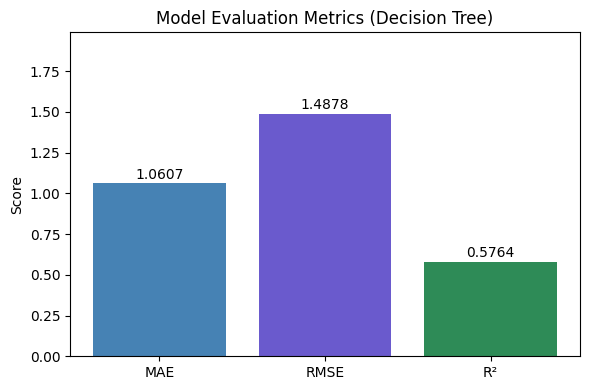

In [38]:
import matplotlib.pyplot as plt

# Define metrics
metrics = ['MAE', 'RMSE', 'R²']
values = [1.0607, 1.4878, 0.5764]

# Create bar plot
plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['steelblue', 'slateblue', 'seagreen'])

# Annotate values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.03, f'{height:.4f}', ha='center', fontsize=10)

plt.title("Model Evaluation Metrics (Decision Tree)")
plt.ylabel("Score")
plt.ylim(0, max(values) + 0.5)
plt.tight_layout()
plt.show()

###  Observation: Decision Tree Model Performance

- The **Mean Absolute Error (MAE)** of **1.0607** indicates that, on average, the model’s predictions deviate from the actual log-transformed resolution times by about **1.06 units**, reflecting a reasonably accurate estimation.
- The **Root Mean Squared Error (RMSE)** is **1.4878**, slightly higher than the MAE, suggesting the presence of some larger errors. However, the difference is not extreme, indicating **moderate error variability**.
- The **R² score** of **0.5764** reveals that the model explains approximately **57.64% of the variance** in the target variable. This represents a **moderate level of explanatory power**.
- Overall, the Decision Tree model shows a **decent generalization ability**, although there is **room for improvement**. Future enhancements could involve using **ensemble techniques** such as Random Forest or Gradient Boosting to capture more complex patterns in the data.


### Residual Analysis and Prediction Accuracy Visualization

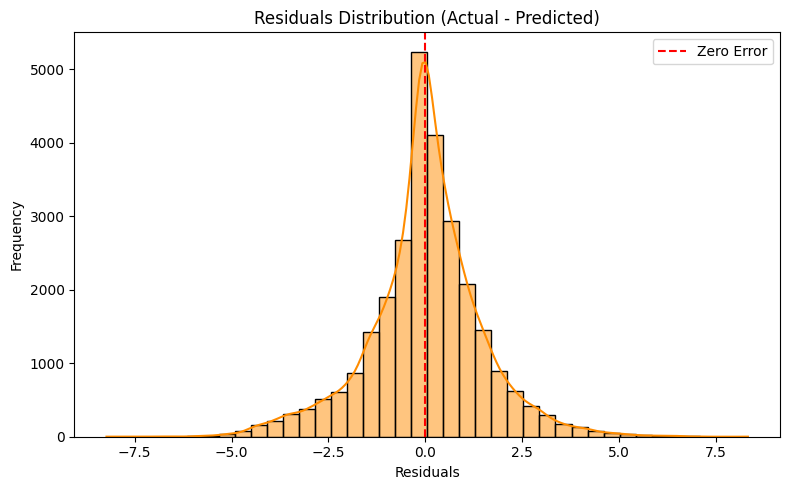

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - y_pred

# Plot histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True, color='darkorange')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.title("Residuals Distribution (Actual - Predicted)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

### Observation: Residuals Distribution (Actual - Predicted)

- The residuals are **approximately centered around zero**, indicating that the Decision Tree model does not exhibit significant systematic bias in over- or under-predicting the target.
- The distribution is **fairly symmetric** with a sharp peak at 0, which is a good sign — most predictions are close to the actual values.
- However, the presence of **long tails on both sides** suggests there are **some extreme errors**, potentially outliers or complex patterns not captured by the model.
- The **red dashed line** at 0 serves as a reference for perfect predictions. Most residuals cluster around this line, validating the model's general accuracy.
- The shape of the distribution resembles a **Laplace-like distribution** rather than a perfect normal curve, which is typical for tree-based models.

**Conclusion:** The Decision Tree regressor performs well overall, with most errors being small and balanced. However, further improvement may be achieved by addressing the few high-error instances through model complexity or ensembling.


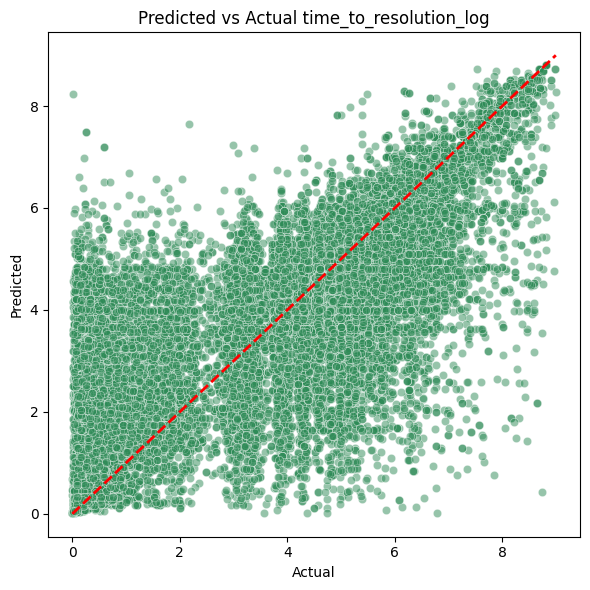

In [40]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='seagreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Predicted vs Actual time_to_resolution_log")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()

### Observation: Predicted vs Actual Plot for `time_to_resolution_log`

- The scatter plot shows a **positive linear trend**, indicating that the Decision Tree model generally captures the relationship between input features and the target variable (`time_to_resolution_log`).
- Many predictions are **clustered closely around the diagonal red dashed line**, which represents perfect predictions (i.e., Predicted = Actual). This is a good sign of **model accuracy**.
- However, there is **noticeable vertical spread** at various actual values, especially in the mid and high ranges. This suggests the model sometimes struggles to consistently predict extreme cases.
- **Underfitting or saturation** can be inferred for actual values above 6, where the model’s predictions become flatter and more dispersed, indicating **reduced sensitivity** to higher resolution times.
- The **blocky patterns** seen in lower actual values (e.g., 0–2) are likely due to the discrete nature of decision tree splits, which create step-like prediction regions.

**Conclusion:** While the Decision Tree model performs reasonably well, especially for moderate values, its predictive power **decreases for extreme cases**. This could be improved with more advanced models like **Random Forests** or **Gradient Boosting**, which reduce variance and capture complex relationships better.


### Top 20 Feature Importances from Decision Tree Regressor

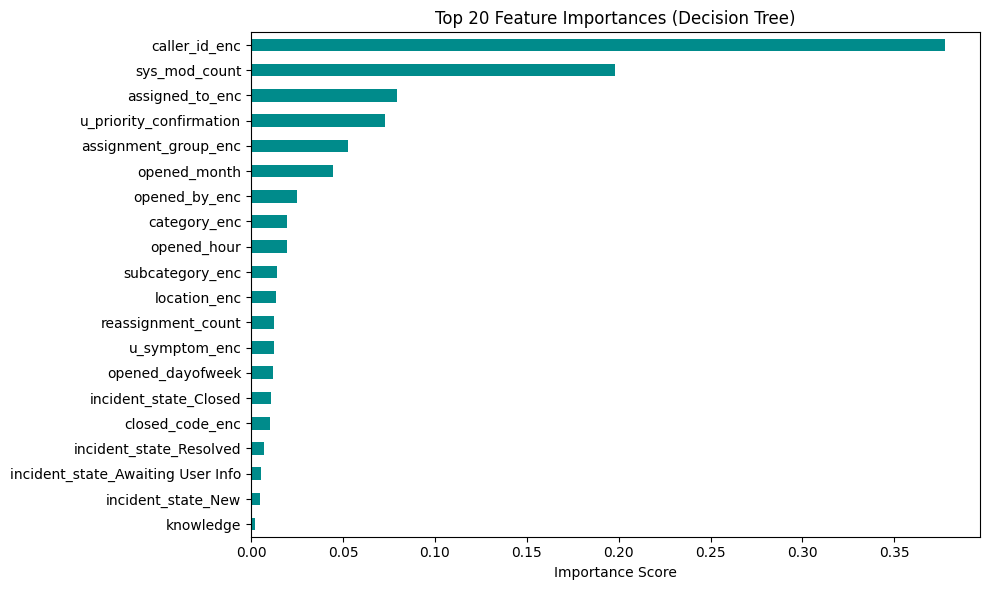

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create importance DataFrame
feat_importances = pd.Series(final_dt.feature_importances_, index=X_train_clean.columns)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 20
plt.figure(figsize=(10, 6))
feat_importances[:20].plot(kind='barh', color='darkcyan')
plt.title("Top 20 Feature Importances (Decision Tree)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [42]:
# Create importance Series
feat_importances = pd.Series(final_dt.feature_importances_, index=X_train_clean.columns)

# Sort and get top 20
top_20 = feat_importances.sort_values(ascending=False).head(20)

# Print as a table
print(" Top 20 Feature Importances (Decision Tree):\n")
print(top_20.to_string(float_format="%.4f"))


 Top 20 Feature Importances (Decision Tree):

caller_id_enc                       0.3777
sys_mod_count                       0.1981
assigned_to_enc                     0.0795
u_priority_confirmation             0.0731
assignment_group_enc                0.0525
opened_month                        0.0446
opened_by_enc                       0.0251
category_enc                        0.0198
opened_hour                         0.0194
subcategory_enc                     0.0141
location_enc                        0.0138
reassignment_count                  0.0127
u_symptom_enc                       0.0125
opened_dayofweek                    0.0120
incident_state_Closed               0.0106
closed_code_enc                     0.0102
incident_state_Resolved             0.0073
incident_state_Awaiting User Info   0.0057
incident_state_New                  0.0049
knowledge                           0.0019


In [44]:
# Saving the final model
import joblib
joblib.dump(final_dt, '../../models/')

['../../models/decision_garment_dataset_best_model.pkl']

### Observation

- The most influential feature is **`caller_id_enc`**, contributing **~37.77%** to the prediction of `time_to_resolution_log`. This indicates that the identity or type of caller has a major impact on how quickly incidents are resolved.
- **`sys_mod_count`** is the second most important feature (**~19.81%**), suggesting that the number of system modifications during the ticket lifecycle significantly affects resolution time.
- Other high-impact features include **`assigned_to_enc`** (~7.95%) and **`u_priority_confirmation`** (~7.31%), emphasizing the importance of assignment and prioritization in efficient resolution.
- Additional contributors such as **`assignment_group_enc`**, **`opened_month`**, and **`opened_by_enc`** provide contextual or operational insights (e.g., seasonality, handler identity) into ticket resolution.
- Many features toward the bottom (e.g., **`knowledge`**, **`incident_state_New`**, **`incident_state_Resolved`**) contribute marginally (less than 1%), indicating that while they are used, their individual predictive power is limited.
- The long-tail distribution of importance scores confirms that a **small set of features dominate** the model’s decision-making, which can inform **feature selection**, **dimensionality reduction**, or **business process optimization**.

**Conclusion:** Focusing on caller identity, system modification patterns, and assignment processes could be key areas for reducing incident resolution times in real-world ITSM scenarios.


## Takeaways from Decision Tree Modeling

- **Caller identity and system modifications** are the strongest predictors of resolution time, highlighting key operational factors in incident management.
- The model achieved **moderate predictive performance** (R² ≈ 0.576), indicating that it captures over half of the variance in log-transformed resolution times.
- **Residuals are centered and symmetric**, suggesting balanced predictions with no major systematic bias.
- **Prediction accuracy declines slightly for extreme cases**, particularly longer resolution times, indicating potential for improvement using more robust models.
- A few features contribute disproportionately to predictions, enabling opportunities for **feature reduction** and **process optimization**.
- Future enhancements could involve using **ensemble models** (e.g., Random Forest, XGBoost) or **engineering richer features** from the temporal and categorical data.

Overall, the Decision Tree provides a solid baseline model and useful interpretability, setting the stage for further modeling improvements.
